# 📌 NYC Restaurant Inspection Risk Prediction

### 🧪 Data Understanding Notebook

This notebook focuses on:

1. **Contextualize the Problem**
   - Understand dataset (schema, summary stats, etc..) and context.
   - Observe the target `risk_category` behavior (should contain Low/Moderate/High values regarding the risk for each violation).
   - Understand how `grade` and `score` relate to public health risk.
   - Clarify missing or ambiguous values (e.g., `N`, `Z`, `P` in `grade`).

2. **Assess Data Quality**
   - Identify irregularities, missing values, duplicates, or inconsistent coding.
   - Examine field-level distributions and formats to guide cleaning.

3. **Lay Groundwork for Data Cleaning**
   - Pinpoint necessary Data Cleaning steps to fix issues before Exploratory Data Analysis.

### 🗺️ Project Context & Field Overview

📍 **Context**: 

- The dataset contains **every sustained or not yet adjudicated violation citation from every full or special program inspection conducted up to three years prior to the most recent inspection for restaurants and college cafeterias** in an active status on the RECORD DATE (date of the data pull). When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record. Establishments are uniquely identified by their CAMIS (record ID) number. Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

- Records are also included for each restaurant that has applied for a permit but has not yet been inspected and for inspections resulting in no violations. Establishments with **inspection date of 1/1/1900 are new establishments that have not yet received an inspection**. Restaurants that received no violations are represented by a single row and coded as **having no violations using the ACTION field**.

- Because this dataset is compiled from several large administrative data systems, **it contains some illogical values that could be a result of data entry or transfer errors. Data may also be missing.**

- This dataset and the information on the Health Department’s Restaurant Grading website come from the same data source. The Health Department’s Restaurant Grading website is [here](http://www1.nyc.gov/site/doh/services/restaurant-grades.page).


🔎 **Source**: [NYC Open Data – Restaurant Inspection Results](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data)


### Field Definitions


According to the [NYC Open Data](https://data.cityofnewyork.us/Health/2019-New-York-City-Restaurant-Inspection-Results/8we4-p22f/about_data):

| Field Name            | Description                                                                                                                                                            | Data Type          |
|-----------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------|
| camis                 |  Unique restaurant identifier                                                                         | Text               |
| dba                   | Public business name of the restaurant                                                                  | Text               |
| boro                  | Borough where the restaurant is located. Values: 1=MANHATTAN, 2=BRONX, 3=BROOKLYN, 4=QUEENS, 5=STATEN ISLAND, Missing. Discrepancies may exist with ZIPCODE.          | Text               |
| building              | Building number of the restaurant location.                                                                                                                             | Text               |
| street                | Street name of the restaurant location.                                                                                                                                 | Text               |
| zipcode               | ZIP code of the restaurant location.                                                                                                                                    | Text               |
| phone                 | Phone number of the restaurant, provided by the owner or manager.                                                                                                       | Text               |
| cuisine_description   | Description of the restaurant's cuisine; optional field provided by the restaurant.                                                                                     | Text               |
| inspection_date       | Date of the health inspection. '1/1/1900' indicates no inspection yet.                                                                                                   | Floating Timestamp |
| action                | Action taken during or as a result of the inspection. May include violations, closures, or re-openings.                                                                 | Text               |
| violation_code        | Code representing a specific violation found during inspection.                                                                                                         | Text               |
| violation_description | Description of the specific violation cited.                                                                                                                            | Text               |
| critical_flag         | Indicates if a violation is critical: 'Critical', 'Not Critical", or "Not Applicable".                                                                                  | Text               |
| score                 | Inspection score; lower scores are better. Can be updated following adjudication.                                                                                       | Number             |
| grade                 | Letter grade assigned to the restaurant based on inspection results. Possible values: A, B, C, N (Not Graded), Z, P (Pending on reopening).                             | Text               |
| grade_date            | Date on which the current grade was issued.                                                                                                                             | Floating Timestamp |
| record_date           | Date on which the dataset extract was generated.                                                                                                                        | Floating Timestamp |
| inspection_type       | Type of inspection performed, based on program and context (e.g., routine, pre-permit).                                                                                 | Text               |
| latitude              | Geographic latitude coordinate of the restaurant location.                                                                                                              | Number             |
| longitude             | Geographic longitude coordinate of the restaurant location.                                                                                                             | Number             |
| community_board       | NYC community board in which the restaurant is located.                                                                                                                 | Text               |
| council_district      | NYC City Council district for the restaurant’s location.                                                                                                                | Text               |
| census_tract          | U.S. Census Tract ID for the restaurant location.                                                                                                                       | Text               |
| bin                   | Building Identification Number assigned by NYC Department of City Planning.                                                                                            | Text               |
| bbl                   | Borough-Block-Lot identifier for the property location.                                                                                                                 | Text               |
| nta                   | Neighborhood Tabulation Area where the restaurant is located; used for NYC planning/statistical purposes.                                                              | Text               |


### Dependencies

In [1]:
import sys
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from os.path import join, abspath

# adding the root folder to the system path
if abspath('..') not in sys.path:
    sys.path.append(abspath('..'))

# import utility components
from src.path_manager import PathManager
import src.data_inspector as data_inspector

# path manager to handle paths
path_manager = PathManager()
raw_data_path = path_manager.raw_data_path

# adding the src folder to the system path
if path_manager.src_path not in sys.path:
    sys.path.append(path_manager.src_path)

### Load Data

In [2]:
# feature types according to NYC open data portal
dtypes = {
    'camis': 'string',
    'dba': 'string',
    'boro': 'string',
    'building': 'string',
    'street': 'string',
    'zipcode': 'string',
    'phone': 'string',
    'cuisine_description': 'string',
    'action': 'string',
    'violation_code': 'string',
    'violation_description': 'string',
    'critical_flag': 'string',
    'score': 'float',
    'grade': 'string',
    'inspection_type': 'string',
    'latitude': 'float',
    'longitude': 'float',
    'community_board': 'string',
    'council_district': 'string',
    'census_tract': 'string',
    'bin': 'string',
    'bbl': 'string',
    'nta': 'string'
}

# date columns to parse
parse_dates = ['inspection_date', 'grade_date', 'record_date']


# import data
df = pd.read_csv(
    join(raw_data_path, 'nyc_rest_inspect.csv'),
    dtype=dtypes,
    parse_dates=parse_dates,
    )

print(f'Dataset originally contains {df.shape[0]} rows and {df.shape[1]} columns regarding {len(set(df.index))} distinct restaurants.', end='\n\n')

display(df.head().style)

Dataset originally contains 100000 rows and 27 columns regarding 100000 distinct restaurants.



,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location_point1
0,50153871,SUSHI & BENTO BY MR LIM,Manhattan,230,PARK AVENUE,10169,6462665642,,1900-01-01 00:00:00,,,,Not Applicable,nan,,NaT,2025-06-02 06:00:14,,40.754501,-73.975950,105,04,009200,1036185,1013000001,MN19,nan
1,50170443,NEW WEST HD LLC,Manhattan,185,GREENWICH STREET,10007,9145140384,,1900-01-01 00:00:00,,,,Not Applicable,nan,,NaT,2025-06-02 06:00:14,,40.711783,-74.012084,101,01,001300,1089309,1000580001,MN25,nan
2,50152716,SHAKE SHACK #1525,Manhattan,10,COLUMBUS CIRCLE,10019,2019656605,,1900-01-01 00:00:00,,,,Not Applicable,nan,,NaT,2025-06-02 06:00:14,,40.767808,-73.982267,104,03,014500,1026318,1010497501,MN14,nan
3,50091872,DOMINO'S,Bronx,3869,WHITE PLAINS ROAD,10467,7186534618,Pizza,2022-10-18 00:00:00,No violations were recorded at the time of this inspection.,,,Not Applicable,0.000000,A,2022-10-18 00:00:00,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,40.885262,-73.861884,212,12,039400,2057657,2046560039,BX44,nan
4,50162584,COZY TEA LOFT,0,141,STATE ROUTE 27,08820,3472619435,,1900-01-01 00:00:00,,,,Not Applicable,nan,,NaT,2025-06-02 06:00:14,,nan,nan,,,,,,,nan


**Initial takeaways**: 

- NYC dataset is at **violation-per-inspection level**, and has mentioned in the Context *"When an inspection results in more than one violation, values for associated fields are repeated for each additional violation record."* , meaning that one inspection with multiple violations will represent various records, but contain inspection-level features.

- **Absence of `risk_category`**. This either changes the scope of the project (supervised task) or the target variable.

    - Another similar dataset but from San Francisco regarding [(2016-2019)](https://data.sfgov.org/Health-and-Social-Services/Health-Inspection-Scores-2016-2019-/pyih-qa8i/about_data) is at the violation-per-inspection level. It contains `risk_category` while `grade` and `critical_flag` were not present. From a inspection in this set, it was observed that **`risk_category` is at the violation-level**, unlike `inspection_score`(the equivalent of `score` on the NYC set). 

    - The same dataset from San Francisco but from [(2024-Present)](https://data.sfgov.org/Health-and-Social-Services/Health-Inspection-Scores-2024-Present-/tvy3-wexg/about_data) dropped `risk_category` and is at the inspection level. Raising concerns that **NYC set might have dropped `risk_category` and replaced it with another feature.

    - **Building this feature would defeat the purpose defined for the challenge which is to create a multiclass classifier model**

    - A better alternative would be to select a proper candidate replacement. One could consider `grade` or `score`, but because these features are at the **inspection-level**, a best candidate could be `critical_flag` which is at the violation-level.

- Data it's **missing unique identifiers of violation-per-inspection (each row) and inspection**.

- `community_board`, `council_district`, `census_tract`, `bin`, `bbl`, and `nta`, are all codes relative to the location. Possible information redundancy among them.

In [3]:
# create copy of original dataset for further processing
tmp = df.copy()

# build unique ID for each restaurant inspection (restaurant id + date)
tmp['inspection_id'] = tmp.apply(
    lambda x: '_'.join([x.camis, x.inspection_date.strftime('%d-%m-%y')]),
    axis=1
)
tmp['inspection_id'] = tmp['inspection_id'].astype('string')

# drop empty violation code rows to generate key (cannot have empty violation codes)
tmp = tmp.dropna(subset='violation_code') 

# create unique key for each row (restaurant id + date + violation code)
tmp['key'] = tmp.apply(
    lambda x: '_'.join([x.camis, x.inspection_date.strftime('%d-%m-%y'), x.violation_code]),
    axis=1
)

# set index to key
tmp = tmp.set_index('key')

print(f'{len(df)-len(tmp)} empty violation code observations were dropped.')

tmp.head().style

2448 empty violation code observations were dropped.


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location_point1,inspection_id
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50006002_27-06-23_04M,50006002,LUCKY CAT,Manhattan,232,EAST 53 STREET,10022,2128385333,Japanese,2023-06-27 00:00:00,Establishment re-closed by DOHMH.,04M,Live roaches in facility's food or non-food area.,Critical,14.000000,,NaT,2025-06-02 06:00:10,Cycle Inspection / Reopening Inspection,40.757332,-73.968553,106,04,009800,1038538,1013260035,MN19,nan,50006002_27-06-23
41719692_22-07-22_02B,41719692,GOOD FELLAS PIZZA,Queens,2519,40 AVENUE,11101,7184721932,Pizza,2022-07-22 00:00:00,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,22.000000,,NaT,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,40.753421,-73.937811,401,26,003300,4004794,4003960037,QN68,nan,41719692_22-07-22
50070541_23-03-22_02B,50070541,LE BOTANISTE,Manhattan,127,GRAND STREET,10013,3478044095,Vegan,2022-03-23 00:00:00,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140º F.,Critical,13.000000,A,2022-03-23 00:00:00,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,40.720594,-74.000213,102,01,004500,1003035,1002320013,MN24,nan,50070541_23-03-22
50058614_10-10-24_09B,50058614,BA SAK CHICKEN,Queens,17107,NORTHERN BLVD,11358,7183538484,Korean,2024-10-10 00:00:00,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,7.000000,A,2024-10-10 00:00:00,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,40.757996,-73.795515,407,19,117500,4438198,4053500001,QN51,nan,50058614_10-10-24
41454244_11-05-23_09B,41454244,COSTA VERDE,Queens,9459,CORONA AVENUE,11373,7182710900,Peruvian,2023-05-11 00:00:00,Violations were cited in the following area(s).,09B,Thawing procedure improper.,Not Critical,11.000000,A,2023-05-11 00:00:00,2025-06-02 06:00:10,Cycle Inspection / Re-inspection,40.742303,-73.869482,404,25,046100,4314507,4016040154,QN29,nan,41454244_11-05-23


### Summary Statistics

In [4]:
# initialize DataInspector
data_inspector_instance = data_inspector.DataInspector(tmp)

# inspect data general info and summary statistics
df_info_describe = data_inspector_instance.inspect()
display(df_info_describe)

# count features per data type 
display(data_inspector_instance.count_types())


Data types, Missing values, and Summary statistics:


,type,NA Count,NA %,mean,min,25%,50%,75%,max,std,unique,top,freq
inspection_date,datetime64[ns],0,0.00,2023-09-24 18:44:26.786944,2015-09-24 00:00:00,2022-11-25 00:00:00,2023-11-06 00:00:00,2024-09-15 00:00:00,2025-05-31 00:00:00,-,-,-,-
record_date,datetime64[ns],0,0.00,2025-06-02 06:00:09.999999232,2025-06-02 06:00:10,2025-06-02 06:00:10,2025-06-02 06:00:10,2025-06-02 06:00:10,2025-06-02 06:00:10,-,-,-,-
grade_date,datetime64[ns],52831,54.16,2023-09-24 23:33:37.709800960,2015-09-24 00:00:00,2022-12-06 00:00:00,2023-11-13 00:00:00,2024-09-18 00:00:00,2025-05-30 00:00:00,-,-,-,-
score,float64,3856,3.95,24.52,0.0,12.0,21.0,32.0,168.0,18.22,-,-,-
longitude,float64,120,0.12,-73.17,-74.25,-73.99,-73.96,-73.9,0.0,7.5,-,-,-
latitude,float64,120,0.12,40.3,0.0,40.68,40.73,40.76,40.91,4.13,-,-,-
location_point1,float64,97552,100.00,-,-,-,-,-,-,-,-,-,-
nta,string,1187,1.22,-,-,-,-,-,-,-,193,MN17,5466
bbl,string,173,0.18,-,-,-,-,-,-,-,18162,1,708
bin,string,1675,1.72,-,-,-,-,-,-,-,18431,4000000,406



Count of features per data type:


,string,float64,datetime64[ns]
count,21,4,3


**Summary Statistics Takeaways:**

- `location_point1` is fully empty and `record_date` is constant, these features add no value and should be dropped.

- `grade` and `grade_date` features have more than 50% of missing values. Could be data entry error since `score`, a feature at the same level only has 4%. `grade_date` is not relevant for this problem.

- There are 138 unique `violation_code` but 210 unique `violation_description`. Are there multiple descriptions for the same violation? Check later.

- 158 rows without lat & long, should be checked.

- `inspection_date` with values "1/1/1900", representing restaurants that were yet to recieve an inspection, were dropped when empty `violation_code` observations were discarded. The minimum value of `inspection_date` is now "2015-09-24".

### Numerical Features - Distribution Check

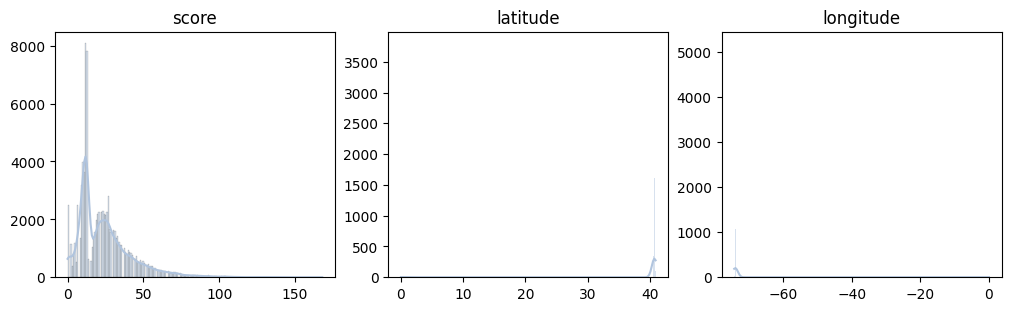

In [5]:
data_inspector_instance.dist_check(x=10, y_per_row=3)

**Continuous Distribution Check**: 

- `score` variable ranges from 0 to 168 and is right-skewed, with a mean around 24. Most values are concentrated below 50, indicating a heavy left-side mass. Values above 100 are rare and may be potential outliers contributing to noise or long-tail effects.

- `latitude` & `longitude` features appear to follow a bimodal distribution and may contain errors, as some values are around zero, which is likely invalid or a placeholder.

### Non-Numerical Features - Values Count

#### Low-Cardinality

Checking for low-cardinality categorical features with up to 7 unique values...


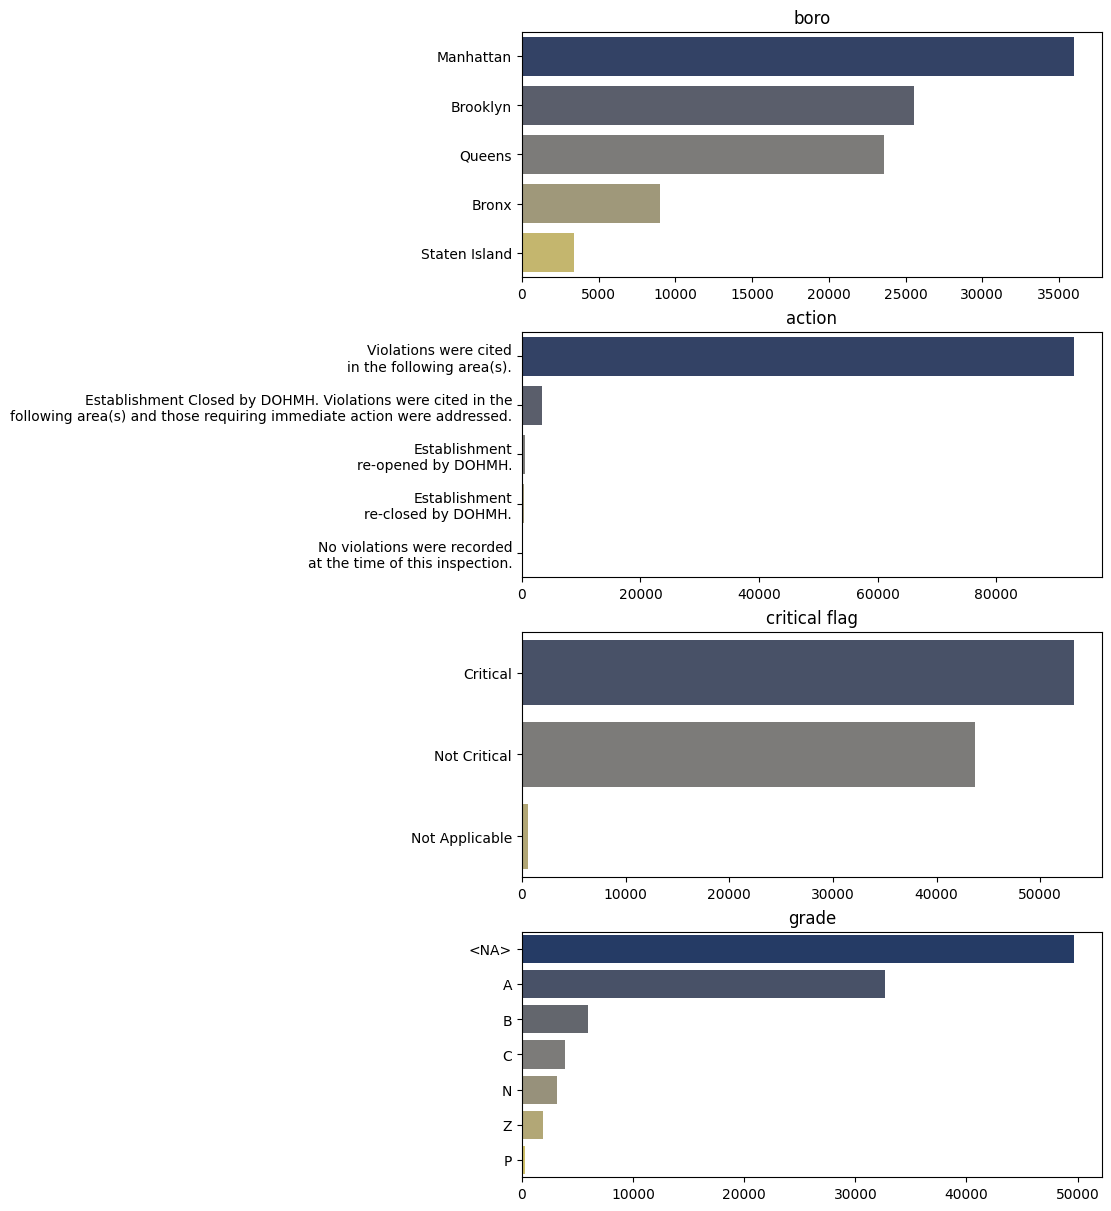

In [6]:
data_inspector_instance.check_low_cardinality_categoricals(x=11, y_per_row=3)

#### High-Cardinality

Checking for high-cardinality categorical features with more than 7 and up to 100 unique values...


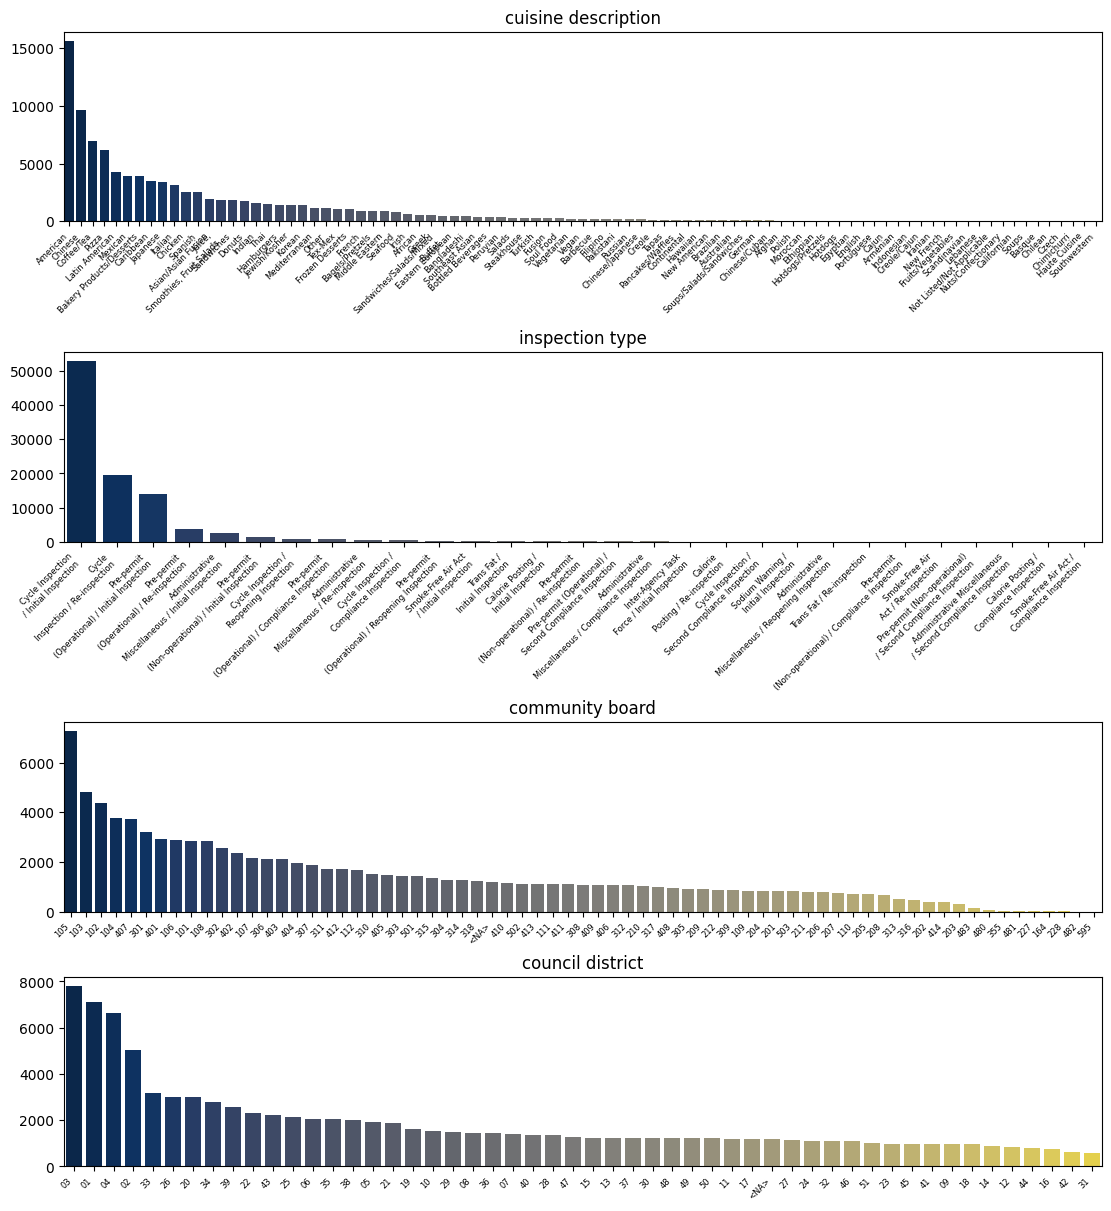

In [7]:
data_inspector_instance.check_high_cardinality_categoricals(x=11, y_per_row=5)

In [8]:
data_inspector_instance.check_high_cardinality_normalization()

Checking high-cardinality categorical features with more than 7 unique values...

⚠️ Warning: "dba" has 19577 unique values, but only 19481 after normalization.
   → Possible duplicates due to casing or whitespace.

⚠️ Warning: "street" has 2217 unique values, but only 2211 after normalization.
   → Possible duplicates due to casing or whitespace.

⚠️ Warning: "violation_description" has 210 unique values, but only 209 after normalization.
   → Possible duplicates due to casing or whitespace.



In [9]:
#check inspection type proportions
display(tmp['inspection_type'].value_counts(normalize=True).reset_index(name='prop').rename(columns={'index': 'inspection_type'}).style)

,inspection_type,prop
0,Cycle Inspection / Initial Inspection,0.542377
1,Cycle Inspection / Re-inspection,0.199043
2,Pre-permit (Operational) / Initial Inspection,0.142047
3,Pre-permit (Operational) / Re-inspection,0.037795
4,Administrative Miscellaneous / Initial Inspection,0.027309
5,Pre-permit (Non-operational) / Initial Inspection,0.012967
6,Cycle Inspection / Reopening Inspection,0.009246
7,Pre-permit (Operational) / Compliance Inspection,0.007196
8,Administrative Miscellaneous / Re-inspection,0.005689
9,Cycle Inspection / Compliance Inspection,0.004244


**Non-Numerical Features Takeaways**:

- `dba`, `street`, and `violation_description` need text normalization to reduce cardinality.

- There are many distinct `inspection_type` values, but its top 3 most frequent types account for the majority of records, indicating a heavy skew towards a few common inspection categories.

### Check for Irregularities

#### Check for duplicates

In [10]:
# check for fully duplicate rows including the 'camis' column
dup_check = tmp[tmp.duplicated(keep=False)]

print(f'There are {dup_check.shape[0]} fully duplicated rows in the dataset.')
if dup_check.shape[0] > 0:
    display(dup_check.style)

There are 2 fully duplicated rows in the dataset.


,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,location_point1,inspection_id
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50001285_28-06-19_04H,50001285,Y & B ENTERTAINMENT MANOR,Queens,3509,PRINCE STRRET,,7188881778,Korean,2019-06-28 00:00:00,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.",Critical,34.000000,,NaT,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,0.000000,0.000000,,,,,4,,nan,50001285_28-06-19
50001285_28-06-19_04H,50001285,Y & B ENTERTAINMENT MANOR,Queens,3509,PRINCE STRRET,,7188881778,Korean,2019-06-28 00:00:00,Violations were cited in the following area(s).,04H,"Raw, cooked or prepared food is adulterated, contaminated, cross-contaminated, or not discarded in accordance with HACCP plan.",Critical,34.000000,,NaT,2025-06-02 06:00:10,Cycle Inspection / Initial Inspection,0.000000,0.000000,,,,,4,,nan,50001285_28-06-19


In [11]:
# drop fully duplicated rows
tmp = tmp.drop_duplicates()

In [12]:
# check for duplicate inspection_id's & violation_code's
dup = tmp[tmp.duplicated(subset=['inspection_id', 'violation_code'], keep=False)]

subset_cols = [
    'camis', 'dba', 'inspection_id', 'action', 'violation_code',
    'critical_flag', 'score', 'grade', 'inspection_type',
]

print(f'There are {dup.shape[0]} inspection_id\'s & violation_code\'s duplicated rows in the dataset.')
if dup.shape[0] > 0:
    display(dup[subset_cols + ['violation_description']].style)

There are 2 inspection_id's & violation_code's duplicated rows in the dataset.


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type,violation_description
key,,,,,,,,,,
40911114_04-11-17_04N,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,04N,Critical,15.000000,,Cycle Inspection / Initial Inspection,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies."
40911114_04-11-17_04N,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,04N,Critical,20.000000,,Cycle Inspection / Initial Inspection,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies."


In [13]:
# check score of this inspection_id 
tmp.loc[tmp.inspection_id == dup.iloc[0].inspection_id, subset_cols + ['violation_description']].style

,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type,violation_description
key,,,,,,,,,,
40911114_04-11-17_08A,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,08A,Not Critical,20.000000,,Cycle Inspection / Initial Inspection,Facility not vermin proof. Harborage or conditions conducive to attracting vermin to the premises and/or allowing vermin to exist.
40911114_04-11-17_04M,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,04M,Critical,15.000000,,Cycle Inspection / Initial Inspection,Live roaches present in facility's food and/or non-food areas.
40911114_04-11-17_04N,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,04N,Critical,15.000000,,Cycle Inspection / Initial Inspection,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies."
40911114_04-11-17_04N,40911114,SWAY LOUNGE,40911114_04-11-17,Violations were cited in the following area(s).,04N,Critical,20.000000,,Cycle Inspection / Initial Inspection,"Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas. Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies. Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies."


**We just found an instance where there are two distinct `score` values for a specific `inspection_id`, pointing for data entry error. Further checking will be done later.**

In [14]:
# check for duplicate inspection_id's
dup = tmp[tmp.duplicated(subset=['inspection_id'], keep=False)]

print(f'There are {dup.shape[0]} duplicate inspection_id\'s in the dataset.')

# let's inspect the top 2 inspections with most duplicate instances
example_top_1 = dup.loc[dup.inspection_id == dup.inspection_id.value_counts().idxmax()]
example_top_2 = dup.loc[dup.inspection_id == dup.inspection_id.value_counts().index[1]]


display(example_top_1[subset_cols].style)
display(example_top_2[subset_cols].style)

There are 67626 duplicate inspection_id's in the dataset.


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type
key,,,,,,,,,
50138297_03-08-23_20-08,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,20-08,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50138297_03-08-23_06F,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,06F,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_20-04,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,20-04,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50138297_03-08-23_04L,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,04L,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_04M,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,04M,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_04N,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,04N,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_06A,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,06A,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_10F,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,10F,Not Critical,64.000000,,Pre-permit (Operational) / Initial Inspection
50138297_03-08-23_04E,50138297,ROCKAWAY GRILL,50138297_03-08-23,Violations were cited in the following area(s).,04E,Critical,64.000000,,Pre-permit (Operational) / Initial Inspection


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type
key,,,,,,,,,
50120714_16-12-24_04N,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,04N,Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_05H,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,05H,Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_04H,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,04H,Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_05A,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,05A,Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_10G,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,10G,Not Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_08C,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,08C,Not Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_02B,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,02B,Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_08A,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,08A,Not Critical,131.000000,,Cycle Inspection / Re-inspection
50120714_16-12-24_04M,50120714,NAZCA PALACE,50120714_16-12-24,Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,04M,Critical,131.000000,,Cycle Inspection / Re-inspection


**Duplicates Takeaways:**

- **Confirms `critical_flag` is at violation-level**, values change across different violations despite being in the same inspection.

- **Confirms that `score`, `grade` & `action` are at inspection-level**

- When `inspection_type` is "Administrative Miscellaneous / Initial Inspection" there is no `score`

- Not every inspection gets graded.

#### No Violation Instances

In [15]:
# check restaurants that received no violations
no_vio = tmp.loc[tmp.action.str.contains('no violations were recorded', case=False, na=False)][subset_cols] 

print(f'There are {no_vio.shape[0]} rows with no violations recorded.')
print(f'A total of {no_vio.score.sum()} inspection points were scored in these inspections.')
print('\nCritical flags in no violation inspections:')
display(pd.DataFrame(no_vio.critical_flag.value_counts()))
print('No violation set:')
display(no_vio[subset_cols].head(20).style)

There are 76 rows with no violations recorded.
A total of 0.0 inspection points were scored in these inspections.

Critical flags in no violation inspections:


,count
critical_flag,
Not Critical,73
Not Applicable,3


No violation set:


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type
key,,,,,,,,,
50089623_27-04-23_28-05,50089623,PROPER FOOD,50089623_27-04-23,No violations were recorded at the time of this inspection.,28-05,Not Critical,0.000000,A,Cycle Inspection / Initial Inspection
41686218_15-06-23_28-03,41686218,BEIT JEDDO,41686218_15-06-23,No violations were recorded at the time of this inspection.,28-03,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50076132_09-01-24_19-06,50076132,MARCY & MYRTLE 2,50076132_09-01-24,No violations were recorded at the time of this inspection.,19-06,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50120707_23-05-25_20-04,50120707,MORNINGSIDE PARK CAFE,50120707_23-05-25,No violations were recorded at the time of this inspection.,20-04,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50113394_07-10-24_19-06,50113394,CHELSEA BAGEL & PIZZERIA,50113394_07-10-24,No violations were recorded at the time of this inspection.,19-06,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50138113_17-07-23_28-06,50138113,VAN LEEUWEN,50138113_17-07-23,No violations were recorded at the time of this inspection.,28-06,Not Critical,0.000000,A,Pre-permit (Operational) / Initial Inspection
50141936_18-09-23_20-08,50141936,HAPPY CAKE BAKERY,50141936_18-09-23,No violations were recorded at the time of this inspection.,20-08,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
41682237_25-07-24_19-10,41682237,"DUNKIN',' BASKIN ROBBINS",41682237_25-07-24,No violations were recorded at the time of this inspection.,19-10,Not Critical,nan,,Administrative Miscellaneous / Initial Inspection
50115369_07-03-24_28-05,50115369,DAYTIME,50115369_07-03-24,No violations were recorded at the time of this inspection.,28-05,Not Critical,0.000000,A,Cycle Inspection / Re-inspection


**No Violation Takeaways**:

- `violation_code` seem different from the normal format in most of these instances, a normal code should include a letter.

- After further studying and according to [What to Expect When You’re Inspected](https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf) and [NYC Food Safety Health Code Reference Tool for Inspectors](https://github.com/nychealth/Food-Safety-Health-Code-Reference/blob/main/Violation-Health-Code-Mapping.csv), these codes are not specific violations but rather "Health Codes" that represent other specificities.

- `critical_flag` values seem to make sense for this context of no violations.

#### Health Codes among Violation Codes

In [16]:
# check for code inconsistencies
mask_no_letters = tmp['violation_code'].str.match(r'^[^A-Za-z]+$') # mask for codes with zero letters

no_letter_subset = tmp.loc[mask_no_letters, ['violation_code']]

codes_without_letters = list(set(no_letter_subset['violation_code'].values))

print(f'There are {len(codes_without_letters)} observation with health codes instead of violation codes.\n')
print('Health codes:\n', codes_without_letters)

There are 44 observation with health codes instead of violation codes.

Health codes:
 ['15-22', '19-06', '28-03', '15-32', '16-01', '18-01', '28-07', '28-04', '18-12', '20-01', '28-05', '18-13', '20-04', '20-07', '19-11', '16-02', '18-11', '28-01', '16-06', '15-27', '18-08', '16-11', '15-21', '16-04', '16-10', '15-33', '19-01', '15-42', '15-37', '18-14', '19-10', '19-04', '16-09', '19-05', '16-03', '19-08', '15-39', '20-08', '20-06', '20-05', '15-01', '16-08', '28-06', '19-07']


In [17]:
# let's check no violation set without health codes
no_vio_no_health = no_vio.loc[~no_vio.violation_code.isin(codes_without_letters)]

print(f'There are {no_vio_no_health.shape[0]} inspections with no violations recorded and no health codes.')
no_vio_no_health

There are 6 inspections with no violations recorded and no health codes.


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type
key,,,,,,,,,
50114428_03-05-22_22A,50114428,53,50114428_03-05-22,No violations were recorded at the time of thi...,22A,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
41395881_30-03-22_22A,41395881,THE VIG BAR,41395881_30-03-22,No violations were recorded at the time of thi...,22A,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
50109619_25-05-22_20A,50109619,EL COCO,50109619_25-05-22,No violations were recorded at the time of thi...,20A,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
50120678_04-04-22_20D,50120678,THE DEAN NYC,50120678_04-04-22,No violations were recorded at the time of thi...,20D,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
50074493_13-02-18_15F7,50074493,PINKY'S SPACE,50074493_13-02-18,No violations were recorded at the time of thi...,15F7,Not Applicable,NaN,<NA>,Smoke-Free Air Act / Initial Inspection
50014568_27-05-22_18G,50014568,INSOMNIA COOKIES,50014568_27-05-22,No violations were recorded at the time of thi...,18G,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection


In [18]:
# are there health codes where action is not 'no violations were recorded'?
health_code_other_actions = tmp.loc[
    (tmp.violation_code.isin(codes_without_letters)) & 
    ~(tmp.action.str.contains('no violations were recorded', case=False, na=False)),
    subset_cols
]

print(f'There are {len(health_code_other_actions)} health codes where action is not "no violations were recorded".')
print('\nCritical flags check:')
display(pd.DataFrame(no_vio.critical_flag.value_counts()))
print('Subset:')
health_code_other_actions.head(10)

There are 3970 health codes where action is not "no violations were recorded".

Critical flags check:


,count
critical_flag,
Not Critical,73
Not Applicable,3


Subset:


,camis,dba,inspection_id,action,violation_code,critical_flag,score,grade,inspection_type
key,,,,,,,,,
50143804_31-12-24_20-06,50143804,HEYTEA,50143804_31-12-24,Violations were cited in the following area(s).,20-06,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
50033154_16-07-24_20-06,50033154,SANDWICH BAR,50033154_16-07-24,Violations were cited in the following area(s).,20-06,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
41620128_06-01-25_20-08,41620128,THINK COFFEE,41620128_06-01-25,Violations were cited in the following area(s).,20-08,Not Critical,NaN,<NA>,Administrative Miscellaneous / Re-inspection
50159852_29-04-25_20-08,50159852,DAILY GROCERY,50159852_29-04-25,Violations were cited in the following area(s).,20-08,Not Critical,NaN,<NA>,Administrative Miscellaneous / Re-inspection
50014942_04-02-25_28-04,50014942,NUHMA,50014942_04-02-25,Violations were cited in the following area(s).,28-04,Not Critical,NaN,<NA>,Administrative Miscellaneous / Re-inspection
50122470_22-11-23_15-21,50122470,SEA TO SOUL,50122470_22-11-23,Violations were cited in the following area(s).,15-21,Not Applicable,NaN,<NA>,Smoke-Free Air Act / Initial Inspection
41476556_28-02-25_18-11,41476556,POPEYES,41476556_28-02-25,Violations were cited in the following area(s).,18-11,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection
40942342_01-06-24_15-21,40942342,LARRY FLYNT'S HUSTLER CLUB,40942342_01-06-24,Violations were cited in the following area(s).,15-21,Not Applicable,NaN,<NA>,Smoke-Free Air Act / Initial Inspection
50048152_31-03-25_20-08,50048152,DOSA ROYALE,50048152_31-03-25,Violations were cited in the following area(s).,20-08,Not Critical,NaN,<NA>,Administrative Miscellaneous / Initial Inspection


In [19]:
# remove health codes from tmp
pre_removal_count = len(tmp)
tmp = tmp.loc[~tmp.violation_code.isin(codes_without_letters)]
print(f'After removing {pre_removal_count - len(tmp)} health code instances, the dataset now contains {len(tmp)} rows.')


After removing 4040 health code instances, the dataset now contains 93511 rows.


**Health Codes among Violation Codes Takeaways**:

- From the 76 rows without any violations recorded, only 6 remain after removing the ones containing health codes. Are these 6 instances necessary for the analysis?

- The remaining health code presence (~4k rows) flags either 'Not Critical' or 'Not Applicable', meaning it does not add relevant information because it does not contain any 'Critical' instance.

- Rows with health codes should be dropped.

#### Scores & Grades 

In [20]:
# check current missing values in 'grade' and 'score' columns
grade_score_na = pd.DataFrame(tmp[['grade', 'score']].isna().sum(), columns=['missing values'])
print('Current missing values in "grade" and "score" columns:')
display(grade_score_na)

Current missing values in "grade" and "score" columns:


,missing values
grade,45876
score,403


In [21]:
# check critical_flag values and count when missing score values
missing_score = tmp.loc[tmp['score'].isna()].copy()
critical_flag_na = missing_score.groupby('critical_flag').size().reset_index(name='count').sort_values(by='count', ascending=False)
display(critical_flag_na)

,critical_flag,count
1,Not Critical,307
0,Not Applicable,96


In [22]:
# check the if what type of inspections were conducted when missing score
inspection_type_na = missing_score.groupby('inspection_type').size().reset_index(name='count').sort_values(by='count', ascending=False)
avg_score_per_type = tmp.groupby('inspection_type')['score'].mean().reset_index()

# merge the two dataframes to get average score per inspection type
inspection_type_na = inspection_type_na.merge(avg_score_per_type, on='inspection_type', how='left')
print('Inspection types with missing score values:')
display(inspection_type_na)

Inspection types with missing score values:


,inspection_type,count,score
0,Administrative Miscellaneous / Initial Inspection,272,NaN
1,Smoke-Free Air Act / Initial Inspection,41,NaN
2,Administrative Miscellaneous / Re-inspection,28,NaN
3,Trans Fat / Initial Inspection,23,NaN
4,Calorie Posting / Initial Inspection,15,NaN
5,Sodium Warning / Initial Inspection,6,NaN
6,Trans Fat / Re-inspection,5,NaN
7,Administrative Miscellaneous / Compliance Insp...,4,NaN
8,Administrative Miscellaneous / Reopening Inspe...,3,NaN
9,Calorie Posting / Re-inspection,3,NaN


In [23]:
# check the if grades were provided when missing score
missing_score['grade'].value_counts()

Series([], Name: count, dtype: Int64)

In [24]:
# check the what violation_code have missing score and how many instances
violation_code_na = missing_score.groupby('violation_code').size().reset_index(name='count').sort_values(by='count', ascending=False)

display(violation_code_na)

,violation_code,count
22,20F,77
20,20D,57
19,20A,49
23,22A,34
27,22F,29
9,16B,28
25,22C,20
4,15F6,17
1,15E2,11
26,22E,10


In [25]:
# check score values for violation codes when score is missing (other than missing values)
na_score_codes = violation_code_na.violation_code.values
check_real_score = tmp[tmp.violation_code.isin(na_score_codes)].groupby('violation_code')['score'].nunique()
check_real_score = check_real_score.reset_index(name='count').query('count > 0').sort_values(by='count', ascending=False)

display(check_real_score)

,violation_code,count
28,22G,1


In [26]:
# only one violation code has a score value, let's check it
irregular_score_code = check_real_score.iloc[0].violation_code
real_score = tmp.loc[tmp.violation_code == irregular_score_code, ['violation_code', 'violation_description', 'inspection_type', 'score']].drop_duplicates()

display(real_score.style)

,violation_code,violation_description,inspection_type,score
key,,,,
50002749_24-03-22_22G,22G,Sale or use of certain expanded polystyrene items restricted,Administrative Miscellaneous / Initial Inspection,nan
40873692_03-10-19_22G,22G,Sale or use of certain expanded polystyrene items restricted,Administrative Miscellaneous / Re-inspection,nan
40398688_07-05-19_22G,22G,Sale or use of certain expanded polystyrene items restricted,Cycle Inspection / Re-inspection,13.000000


In [27]:
# check crosstab of grade with inspection type
grade_inspectype_crosstab = pd.crosstab(tmp['grade'], tmp['inspection_type'])
print('Crosstab of grade with inspection_type:')
display(grade_inspectype_crosstab)

Crosstab of grade with inspection_type:


inspection_type,Cycle Inspection / Initial Inspection,Cycle Inspection / Re-inspection,Cycle Inspection / Reopening Inspection,Inter-Agency Task Force / Initial Inspection,Pre-permit (Non-operational) / Compliance Inspection,Pre-permit (Non-operational) / Initial Inspection,Pre-permit (Non-operational) / Re-inspection,Pre-permit (Non-operational) / Second Compliance Inspection,Pre-permit (Operational) / Initial Inspection,Pre-permit (Operational) / Re-inspection,Pre-permit (Operational) / Reopening Inspection
grade,,,,,,,,,,,
A,18287,9149,3,0,0,0,0,0,3585,1555,0
B,1,4944,0,0,0,0,0,0,1,961,0
C,2,3066,103,0,0,0,0,0,4,659,14
N,523,9,0,2,8,379,52,3,2120,14,6
P,0,0,247,0,0,0,0,0,0,0,52
Z,0,1428,108,0,0,0,0,0,0,322,28


In [28]:
# check crosstab of grade with critical flag
grade_critical_flag_crosstab = pd.crosstab(tmp['grade'], tmp['critical_flag'])
print('Crosstab of grade with critical flag:')
display(grade_critical_flag_crosstab)

Crosstab of grade with critical flag:


critical_flag,Critical,Not Critical
grade,,
A,14927,17652
B,3746,2161
C,2522,1326
N,1886,1230
P,94,205
Z,1135,751


In [29]:
# check score range per grade
grade_score = tmp.groupby('grade')['score'].agg(['min', 'max', 'mean']).reset_index()
print('Score range per grade:')
display(grade_score)

Score range per grade:


,grade,min,max,mean
0,A,0.0,43.0,10.057460
1,B,0.0,102.0,22.169121
2,C,0.0,154.0,41.392931
3,N,0.0,168.0,31.572850
4,P,2.0,27.0,8.598662
5,Z,2.0,108.0,32.227996


In [30]:
# check if there are inspections with multiple grades including NaN grades
n_unique_grades_per_inspect_nan = tmp.groupby('inspection_id')['grade'].nunique(dropna=False).reset_index(name='n_unique_grades').query('n_unique_grades > 1')
print(f'There are {n_unique_grades_per_inspect_nan.shape[0]} inspections with multiple grades considering missing values.')

# check if there are inspections with multiple grades excluding NaN grades
n_unique_grades_per_inspect = tmp.groupby('inspection_id')['grade'].nunique().reset_index(name='n_unique_grades').query('n_unique_grades > 1')
print(f'There are {n_unique_grades_per_inspect.shape[0]} inspections with multiple grades excluding missing values.')

There are 96 inspections with multiple grades considering missing values.
There are 0 inspections with multiple grades excluding missing values.


,count all,perc all,count most recent,perc most recent
grade,,,,
A,"32,579.00",68.39,"25,020.00",76.25
B,"5,907.00",12.40,"3,289.00",10.02
C,"3,848.00",8.08,"1,660.00",5.06
N,"3,116.00",6.54,"1,645.00",5.01
P,299.00,0.63,240.00,0.73
Z,"1,886.00",3.96,957.00,2.92


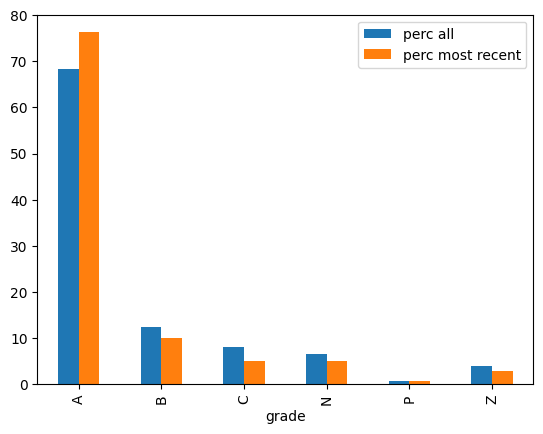

In [31]:
gb_all = tmp.groupby('grade').grade.agg(['count'])
gb_all['perc'] = gb_all / gb_all.sum() * 100

gb_recent = tmp.sort_values('inspection_date', ascending=False).drop_duplicates('inspection_id').groupby('grade').grade.agg(['count'])
gb_recent['perc'] = gb_recent / gb_recent.sum() * 100

gb_all = gb_all.join(gb_recent,lsuffix=' all', rsuffix=' most recent')#

gb_all[['perc all', 'perc most recent']].plot(kind='bar')
gb_all.style.format('{:,.2f}')

**Scores & Grades Takeaways**:

- `score` has 403 observations missing values, only classified as "Not Critical" and "Not Applicable". We **figured that some inspection type, namelly "Administrative Miscellaneous / Initial Inspection" did not provide any score**, explaining the lack of value in these instances. We also found that `violation_code` "22G", was the only one scored on another type of inspection ("Cycle Inspection / Re-inspection").

- Rows without `score` do not add relevant info to predict `critical_flag`, these instances are deemed to be dropped.

- According to [What to Expect When You’re Inspected](https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf), DOHMH assigns a **letter grade** based on the number and severity of violations recorded during an inspection. These map directly to score ranges seen in `grade`:

    | DOHMH Grade | Score Range | Interpretation       |
    |-------------|-------------|----------------------|
    | A           | 0–13        | Low Risk             |
    | B           | 14–27       | Moderate Risk        |
    | C           | 28+         | High Risk            |
    | N, Z, P     | —           | Not Graded / Pending |

<br>

- The risk/critical interpretation is grounded in official DOHMH guidelines and NYC-based summaries (e.g., [Letter Grading for Restaurants](https://www.nyc.gov/site/doh/business/food-operators/letter-grading-for-restaurants.page#:~:text=Since%202010%2C%20New%20York%20City,seen%20by%20people%20passing%20by), [What to Expect When You’re Inspected, page 5, "Grading"](https://www.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf)).

- This official source also mentions: *"A restaurant that scores 0 to 13 violation points on its first inspection will receive an A-grade card that must be posted immediately. An establishment that does not score an A on its initial inspection will not have to post a grade until it has had the opportunity to improve its sanitary conditions and is re-inspected If an A is issued on re-inspection, the A-grade card must be posted immediately An establishment receiving a B or C grade on re-inspection receives two cards: one showing the letter grade and one that says “Grade Pending”; one of those cards must be posted immediately. The final grade is determined at OATH (Office of Trials and Hearings)"*.

- Context from [NYC Open Data – Restaurant Inspection Results](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data) states that there are some illogical values that could be a result of data entry or transfer errors and that data may also be missing, because this dataset is compiled from several large administrative data systems.

- [About Restaurant Inspection Data from NYC Open Data](https://data.cityofnewyork.us/api/views/43nn-pn8j/files/0658bb14-1b0a-4fc6-b389-d42ae6e9d3be?download=true&filename=About_NYC_Restaurant_Inspection_Data_on_NYC_OpenData_050222.docx) confirms this by addressing that *"The SCORE and GRADE fields may be inconsistent with each other because of limitations or errors in the data systems. That is to say, scores of 0-13, 14-27 and 28+ are not always accompanied by A, B and C grades, respectively, when they should be."* meaning that missing values of graded inspections should not exist.

- This source also states *"Not every inspection is a “gradable” inspection. Gradable inspections can be identified when the following statements are true: INSPECTION TYPE in (Cycle Inspection/Initial Inspection, Cycle Inspection/Re-Inspection, Pre-Permit (Operational)/Initial Inspection, Pre-Permit (Operational)/Re-Inspection) ACTION in (Violations were cited in the following area(s), No violations were recorded at the time of this inspection, Establishment Closed by DOHMH). Although this logic will identify gradable inspections, grades associated with a closing inspection are not assigned until the reopening inspection."*

- `score` shows either a final grade (after a restaurant challenges it—adjudicated) or a preliminary one (if they haven’t or won't challenge it). Dismissed violations from successful challenges are later removed from the dataset.

#### Violation Code & Description

In [32]:
# check which codes have multiple descriptions
code_desc_tmp = tmp.groupby('violation_code', as_index=False)['violation_description'].nunique().sort_values(by='violation_description', ascending=False)

code_desc_tmp = code_desc_tmp.loc[code_desc_tmp['violation_description'] > 1].reset_index(drop=True)

print(f'There are {code_desc_tmp.shape[0]} violation codes with multiple descriptions.\n\n')

# check the top 10 codes with multiple descriptions
print('Top 10 violation codes with multiple descriptions:')
code_desc_tmp.head(10)

There are 51 violation codes with multiple descriptions.


Top 10 violation codes with multiple descriptions:


,violation_code,violation_description
0,05C,4
1,06A,4
2,06C,4
3,02A,3
4,03E,3
5,05B,3
6,05H,3
7,04N,3
8,04F,3
9,04D,3


In [33]:
# check the descriptions from top 3 violation codes with most unique descriptions
top_5_codes = list(code_desc_tmp.iloc[:5].violation_code)
top_5_codes_desc = tmp.loc[tmp.violation_code.isin(top_5_codes), ['violation_code', 'violation_description']].drop_duplicates()

for code in top_5_codes:
    code_subset = top_5_codes_desc[top_5_codes_desc['violation_code'] == code].reset_index(drop=True)
    desc = code_subset[['violation_description']]
    print(f'Violation code: {code}')
    display(desc.style)
    print('\n')

Violation code: 05C


,violation_description
0,"Food contact surface, refillable, reusable containers, or equipment improperly constructed, placed or maintained. Unacceptable material used. Culinary sink or other acceptable method not provided for washing food."
1,"Food contact surface, refillable, reusable containers, or equipment improperly constructed, placed or maintained. Unacceptable material used. Culinary sink or other acceptable method not provided for washing food."
2,"Design, construction, materials used or maintenance of food contact surface improper. Surface not easily cleanable, sanitized and maintained. Culinary sink or other acceptable method not provided for washing food."
3,Food contact surface improperly constructed or located. Unacceptable material used.




Violation code: 06A


,violation_description
0,Personal cleanliness is inadequate. Outer garment soiled with possible contaminant. Effective hair restraint not worn where required. Jewelry worn on hands or arms. Fingernail polish worn or fingernails not kept clean and trimmed.
1,Personal cleanliness inadequate. Outer garment soiled with possible contaminant. Effective hair restraint not worn in an area where food is prepared.
2,Personal cleanliness is inadequate. Outer garment soiled with possible contaminant. Effective hair restraint not worn where required. Jewelry is worn on hands or arms. Fingernail polish worn or fingernails not kept clean and trimmed.
3,Personal cleanliness is inadequate. Outer garment soiled with possible contaminant. Effective hair restraint not worn where required. Jewelry worn on hands or arms. Fingernail polish worn or fingernails not kept clean and trimmed.




Violation code: 06C


,violation_description
0,"Food, supplies, or equipment not protected from potential source of contamination during storage, preparation, transportation, display, service or from customer’s refillable, reusable container. Condiments not in single-service containers or dispensed directly by the vendor."
1,"Food not protected from potential source of contamination during storage, preparation, transportation, display or service."
2,"Food, supplies, and equipment not protected from potential source of contamination during storage, preparation, transportation, display or service."
3,"Food, supplies, or equipment not protected from potential source of contamination during storage, preparation, transportation, display, service or from customer’s refillable, reusable container. Condiments not in single-service containers or dispensed directly by the vendor."




Violation code: 02A


,violation_description
0,Food not cooked to required minimum temperature.
1,"Time/Temperature Control for Safety (TCS) food not cooked to required minimum internal temperature. • Poultry, poultry parts, ground and comminuted poultry, all stuffing containing poultry, meats, fish or ratites to or above 165 °F for 15 seconds with no interruption of the cooking process • Ground meat, and food containing ground and comminuted meat, to or above 158 °F for 15 seconds with no interruption of the cooking process, except per individual customer request• Pork, any food containing pork to or above 150 °F for 15 seconds• Mechanically tenderized or injected meats to or above 155 °F.• Whole meat roasts and beef steak to or above required temperature and time except per individual customer request• Raw animal foods cooked in microwave to or above165 °F, covered, rotated or stirred • All other foods to or above 140 °F for 15 seconds; shell eggs to or above 145 °F for 15 seconds except per individual customer request."
2,"Time/Temperature Control for Safety (TCS) food not cooked to required minimum internal temperature. • Poultry, poultry parts, ground and comminuted poultry, all stuffing containing poultry, meats, fish or ratites to or above 165 °F for 15 seconds with no interruption of the cooking process • Ground meat, and food containing ground and comminuted meat, to or above 158 °F for 15 seconds with no interruption of the cooking process, except per individual customer request • Pork, any food containing pork to or above 150 °F for 15 seconds • Mechanically tenderized or injected meats to or above 155 °F. • Whole meat roasts and beef steak to or above required temperature and time except per individual customer request • Raw animal foods cooked in microwave to or above165 °F, covered, rotated or stirred • All other foods to or above 140 °F for 15 seconds; shell eggs to or above 145 °F for 15 seconds except per individual customer request."




Violation code: 03E


,violation_description
0,Potable water supply inadequate. Water or ice not potable or from unapproved source. Cross connection in potable water supply system observed.
1,No or inadequate potable water supply. Water or ice not potable or from unapproved source. Bottled water not NY State certified. Cross connection in potable water supply system.
2,No or inadequate potable water supply. Water or ice not potable or from unapproved source. Bottled water not NY State certified. Cross connection in potable water supply system.


In [34]:
# check if critical_flag varies within the same violation code
tmp_critical_flag = tmp.groupby(['violation_code', 'critical_flag']).size().reset_index(name='count')
tmp_critical_flag = tmp_critical_flag.pivot(index='violation_code', columns='critical_flag', values='count').fillna(0).reset_index()

# count how many non-zero critical_flag values each violation code has
tmp_critical_flag['non_zero_flags'] = tmp_critical_flag[['Critical', 'Not Critical', 'Not Applicable']].gt(0).sum(axis=1)

# get rows where more than one critical_flag is used
inconsistent_flags = tmp_critical_flag[tmp_critical_flag['non_zero_flags'] > 1]

print(f'Found {len(inconsistent_flags)} violation codes with inconsistent critical_flag usage:')
display(inconsistent_flags.drop(columns='non_zero_flags').style)

Found 1 violation codes with inconsistent critical_flag usage:


critical_flag,violation_code,Critical,Not Applicable,Not Critical
50,09A,55.000000,0.000000,194.000000


In [35]:
# check critical flags per violation description on the inconsistent violation code
check_irregular = tmp.loc[tmp.violation_code.isin([inconsistent_flags.violation_code.iloc[0]]), ['violation_code', 'violation_description', 'critical_flag']]


print(f'Checking critical flags per description for violation code {inconsistent_flags.violation_code.iloc[0]}:')
pd.crosstab(check_irregular.critical_flag, check_irregular.violation_description)

Checking critical flags per description for violation code 09A:


violation_description,Canned food product observed dented and not segregated from other consumable food items.,"Swollen, leaking, rusted or otherwise damaged canned food to be returned to distributor not segregated from intact product and clearly labeled DO NOT USE"
critical_flag,,
Critical,0,55
Not Critical,38,156


**Violation Code & Description Takeaways**: 

- 51 of the 138 violation codes have more than one description associated in this dataset.

- Descriptions may vary in some details, but the violation is the same at a high level.

- Only **one `violation_code` (09A) is inconsitent in terms of having multiple `critical_flag` distinct values**. This code revealed 55 Critical instances among 249 records (the remainder are Not Critical), however based on the severity of the problem, inspectors could have deemed it "Critical".

#### Latitude & Longitude

In [36]:
# check stores with missing latitude or longitude & compare with unique restaurant missing coordinates
missing_coords = tmp[(tmp['latitude'].isna()) & (tmp['longitude'].isna())].copy()
n_rows_missing_coords = missing_coords.shape[0]
n_restaurants_missing_coords = missing_coords.dba.nunique()
print(f'There are {n_rows_missing_coords} rows with missing latitude and longitude coordinates, from {n_restaurants_missing_coords} distinct restaurants.')

There are 118 rows with missing latitude and longitude coordinates, from 56 distinct restaurants.


In [37]:
# check other location features values for restaurants with missing coordinates
display(missing_coords[['community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta']].drop_duplicates())

,community_board,council_district,census_tract,bin,bbl,nta
key,,,,,,
50143076_28-05-25_02B,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [38]:
# check boroughs of restaurants with missing coordinates
print('Boroughs of restaurants with missing coordinates:')
display(missing_coords.boro.value_counts().reset_index(name='count').style.format({'count': '{:,.0f}'}))

Boroughs of restaurants with missing coordinates:


,boro,count
0,Queens,76
1,Manhattan,33
2,Bronx,6
3,Brooklyn,3


In [39]:
# check critical_flag values and count when missing coordinates
critical_flag_na = missing_coords.groupby('critical_flag').size().reset_index(name='count').sort_values(by='count', ascending=False)
display(critical_flag_na)

,critical_flag,count
1,Not Critical,62
0,Critical,56


In [40]:
# check rows with lat, long around 0, 0
near_zero_coords = tmp[(tmp['latitude'].abs() < 0.01) & (tmp['longitude'].abs() < 0.01)].copy()
print(f'There are {near_zero_coords.shape[0]} rows with latitude and longitude coordinates around (0, 0).')

There are 979 rows with latitude and longitude coordinates around (0, 0).


In [41]:
# check critical_flag values and count when coordinates are around (0, 0)
critical_flag_na = near_zero_coords.groupby('critical_flag').size().reset_index(name='count').sort_values(by='count', ascending=False)
display(critical_flag_na)

,critical_flag,count
0,Critical,537
2,Not Critical,439
1,Not Applicable,3


In [42]:
# check other location features values for restaurants with coordinates around (0, 0)
display(near_zero_coords[['community_board', 'council_district', 'census_tract', 'bin', 'bbl', 'nta']].drop_duplicates())

,community_board,council_district,census_tract,bin,bbl,nta
key,,,,,,
50075707_21-10-24_02B,<NA>,<NA>,<NA>,<NA>,4,<NA>
41569764_17-08-21_02B,<NA>,<NA>,<NA>,<NA>,3,<NA>
50033699_09-11-22_02B,<NA>,<NA>,<NA>,<NA>,1,<NA>
50102205_01-02-24_02B,<NA>,<NA>,<NA>,<NA>,2,<NA>
41431222_20-03-24_09C,<NA>,<NA>,<NA>,<NA>,5,<NA>
50119035_22-01-24_10F,<NA>,<NA>,<NA>,5057603,5042210042,<NA>
50078417_05-04-23_06A,<NA>,<NA>,<NA>,4594823,4004180024,<NA>
41414670_12-02-25_04L,<NA>,16,017701,2002074,2024260048,<NA>
50161108_08-04-25_06D,<NA>,<NA>,<NA>,4037049,4015010054,<NA>


**Latitude & Longitude Takeaways**:

- These rows are simply missing it's geographic coordinates, (0, 0) instances might've been a strategy to fill missing values or just an error, and NaN observations simply lack.

- Geographical component might not be critical, so rows with missing `latitude` and `longitude` will have those values filled with coordinates set to 0.

#### Inspection Date

In [43]:
missing_dates = tmp['inspection_date'].isna().sum()
print(f'Missing inspection dates: {missing_dates}')

Missing inspection dates: 0


In [44]:
# check the range of inspection dates
print('Inspection date range:')
tmp = tmp.sort_values('inspection_date')
print(f'The dataset contains inspection dates from {tmp["inspection_date"].min().strftime("%d-%m-%Y")} to {tmp["inspection_date"].max().strftime("%d-%m-%Y")}.')

Inspection date range:
The dataset contains inspection dates from 24-09-2015 to 31-05-2025.


In [45]:
id_date_counts = tmp.groupby('inspection_id')['inspection_date'].nunique()
inconsistent_ids = id_date_counts[id_date_counts > 1]
if not inconsistent_ids.empty:
    print("Warning: Some inspection_ids have multiple inspection_dates:")
    print(inconsistent_ids)
else:
    print("All inspection_ids map to a single inspection_date.")

All inspection_ids map to a single inspection_date.


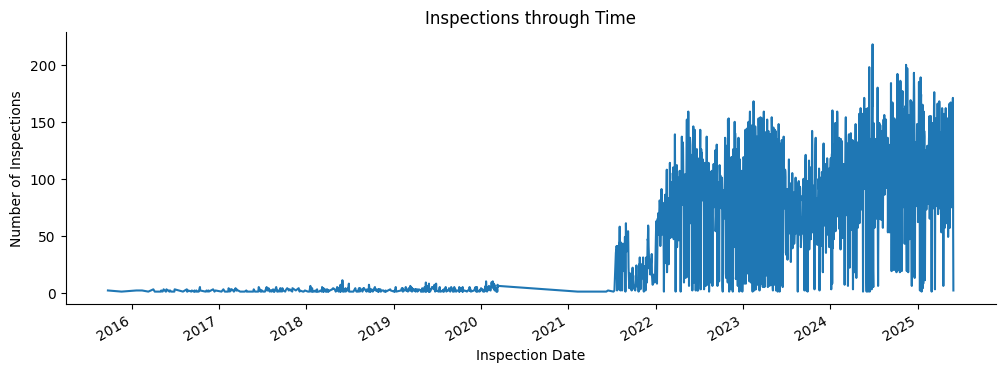

In [46]:
inspections_per_date = tmp['inspection_date'].value_counts().sort_index()
inspections_per_date.plot(kind='line', figsize=(12,4), title='Inspections through Time')
plt.xlabel('Inspection Date')
plt.ylabel('Number of Inspections')
sns.despine()
plt.show()

In [47]:
# check inspection type sequences for each restaurant
tmp_sorted = tmp.sort_values(['camis', 'inspection_date'])

# group by camis, aggregate inspection_type sequence (with duplicates, ordered)
sequences = tmp_sorted.groupby('camis')['inspection_type'].apply(list)

# count unique sequences
sequence_counts = Counter(tuple(seq) for seq in sequences)

# create a DataFrame from the sequence counts
df_workflows = (
    pd.DataFrame(sequence_counts.items(), columns=['inspection_sequence', 'count'])
    .sort_values('count', ascending=False)
    .reset_index(drop=True)
)

print(f'There are {df_workflows.shape[0]} unique inspection sequences in the dataset.')
print('Top 10 inspection sequences:')
display(df_workflows.head(10).style)

There are 2870 unique inspection sequences in the dataset.
Top 10 inspection sequences:


,inspection_sequence,count
0,"('Cycle Inspection / Initial Inspection',)",2435
1,"('Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",2182
2,"('Pre-permit (Operational) / Initial Inspection',)",1882
3,"('Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",1466
4,"('Pre-permit (Operational) / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection')",932
5,"('Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",768
6,"('Pre-permit (Operational) / Initial Inspection', 'Cycle Inspection / Initial Inspection')",511
7,"('Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection')",441
8,"('Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection')",435
9,"('Pre-permit (Operational) / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection')",356


In [48]:
# get first inspection type for each camis workflow
first_inspections = df_workflows['inspection_sequence'].apply(lambda seq: seq[0] if len(seq) > 0 else None)

# check workflows starting NOT with an "Initial Inspection"
non_initial_start = df_workflows[first_inspections.apply(lambda x: not x or 'Initial Inspection' not in x)]

print(f'There are {non_initial_start.shape[0]} workflows that do not start with an "Initial Inspection".')
print('Workflows starting without an Initial Inspection:')
display(non_initial_start.head(10).style)

There are 521 workflows that do not start with an "Initial Inspection".
Workflows starting without an Initial Inspection:


,inspection_sequence,count
13,"('Cycle Inspection / Re-inspection',)",228
23,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Initial Inspection')",157
27,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",131
33,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Re-inspection')",106
41,"('Pre-permit (Operational) / Re-inspection',)",72
48,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Re-inspection', 'Cycle Inspection / Initial Inspection')",61
51,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",59
54,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Re-inspection', 'Cycle Inspection / Initial Inspection', 'Cycle Inspection / Initial Inspection')",55
79,"('Cycle Inspection / Re-inspection', 'Cycle Inspection / Re-inspection', 'Cycle Inspection / Re-inspection')",30
80,"('Pre-permit (Operational) / Re-inspection', 'Cycle Inspection / Initial Inspection')",30


#### Inspection Type

In [49]:
# Count number of unique inspection types per inspection_id
inspection_type_counts = tmp.groupby('inspection_id')['inspection_type'].nunique()

# Filter inspection_ids that have more than one type (inconsistent)
inconsistent_ids = inspection_type_counts[inspection_type_counts > 1].index

# Show rows with inconsistent inspection_type per inspection_id
inconsistent_rows = tmp[tmp['inspection_id'].isin(inconsistent_ids)]

col_subset = [
    'camis', 'dba', 'inspection_id', 'inspection_date', 
    'inspection_type', 'action', 'violation_code', 
    'critical_flag', 'score'
]
print(f"Found {len(inconsistent_ids)} inspection_id(s) with multiple inspection types.")

combo_counts = (
    tmp[tmp['inspection_id'].isin(inconsistent_ids)]
    .groupby('inspection_id')['inspection_type']
    .unique()
    .apply(tuple)
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'inspection_type_combinations', 'inspection_type': 'count'})
)

combo_counts.head(10).style

Found 272 inspection_id(s) with multiple inspection types.


,count,count
0,"('Cycle Inspection / Initial Inspection', 'Administrative Miscellaneous / Initial Inspection')",75
1,"('Administrative Miscellaneous / Initial Inspection', 'Cycle Inspection / Initial Inspection')",57
2,"('Administrative Miscellaneous / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection')",19
3,"('Pre-permit (Operational) / Initial Inspection', 'Administrative Miscellaneous / Initial Inspection')",17
4,"('Cycle Inspection / Re-inspection', 'Administrative Miscellaneous / Re-inspection')",10
5,"('Cycle Inspection / Initial Inspection', 'Trans Fat / Initial Inspection')",8
6,"('Smoke-Free Air Act / Initial Inspection', 'Cycle Inspection / Initial Inspection')",6
7,"('Cycle Inspection / Initial Inspection', 'Smoke-Free Air Act / Initial Inspection')",6
8,"('Pre-permit (Non-operational) / Initial Inspection', 'Administrative Miscellaneous / Initial Inspection')",5
9,"('Administrative Miscellaneous / Initial Inspection', 'Pre-permit (Non-operational) / Initial Inspection')",5


### Pinpoint Data Cleaning Steps & Note for EDA

1. Remove Uninformative or Redundant Columns
- Drop columns that are fully empty or constant (e.g., `location_point1`, `record_date`).
- Consider dropping location codes (`community_board`, `council_district`, `census_tract`, `bin`, `bbl`, `nta`) if not used for spatial analysis, as they may be redundant.
- Drop not relevant features (e.g., `grade_date`)


2. Remove Rows with Invalid or Missing Inspection Dates
- Drop rows where `inspection_date` is `'1/1/1900'` (not yet inspected).
- Drop rows with missing `inspection_date`.


3. Remove or Impute Rows with Missing or Invalid Key Fields
- Drop rows with missing `critical_flag` (target variable).
- Drop rows with missing `violation_code`.
- Drop rows with missing `score` if `score`.


4. Remove Health Code Rows
- Drop rows where `violation_code` does **not** contain any letters (i.e., health codes, not actual violations).


5. Handle Duplicates
- Drop fully duplicated rows.
- For partial duplicates (same `inspection_id` and `violation_code`), investigate and resolve inconsistencies, if Critical assume the row with highest score, else the lowest.
- Ensure each row is uniquely identified by `camis`, `inspection_date`, and `violation_code`.


6. Handle Inconsistent or Ambiguous Grades
- Fix `grade` feature according to `score` and the thresholds defined by DOHMH.


7. Handle Missing or Invalid Coordinates
- For rows with missing or zero `latitude`/`longitude`, decide whether to:
  - Impute with a placeholder (e.g., 0, 0) if spatial analysis is not critical.
  - Drop if location becomes essential.


8. Normalize Text Fields
- Standardize text fields (`dba`, `street`, `violation_description`) to reduce cardinality (e.g., lowercase, strip whitespace, remove special characters).


9. Address High Cardinality Categorical Variables (higher than 7  unique values)
- For features like `dba`, `phone`, or `violation_description`, consider:
  - Encode only the most frequent categories.
  - Group rare categories as "Other".


10. Final Sanity Checks
- Check for any remaining missing values in key fields (e.g., `grade`).